In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from geonamescache.mappers import country
import re
import matplotlib.pyplot as plt

In [2]:
##Company details
companies = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/d934844e-5182-4b58-b896-4ba2a499aa57/companies.txt', sep='\t',  encoding = 'ANSI')

##Funding round details
rounds2 = pd.read_csv('file:///C:/Users/Harika/Documents/ML & AI/rounds2.csv',  encoding = 'ANSI')

##Sector Classification
Sector_mapping = pd.read_csv('file:///C:/Users/Harika/Documents/ML & AI/mapping.csv',  encoding = 'ANSI')

In [3]:
##Converting to letters to lower case and removing unwanted text from permalink column
companies['permalink'] = companies['permalink'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [4]:
##Calculating no. of unique companies 
companies['permalink'].nunique()

66368

In [5]:
##unique companies in rounds2
#converting to lowercase letters
rounds2['company_permalink'] = rounds2['company_permalink'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [6]:
##Calculating no. of unique companies 
rounds2['company_permalink'].nunique()

66368

In [7]:
##merging rounds2 & companies dataframes to create master_frame
master_frame = pd.merge(rounds2,companies,how='inner',left_on ='company_permalink', right_on = 'permalink')

In [8]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 16 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
permalink                  114949 non-null object
name                       114948 non-null object
homepage_url               108815 non-null object
category_list              111539 non-null object
status                     114949 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94428 non-null object
dtypes: float64(1), object(15)
memory usage: 14.9+ MB


In [9]:
# removing redundant columns
master_frame =  master_frame.drop(['company_permalink'], axis=1) 

In [10]:
##Checking the percentage of missing values in each column
percent_missing = ((master_frame.isnull() | master_frame.isna()).sum() * 100 / master_frame.index.size)
print(percent_missing)

funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.909725
funded_at                   0.000000
raised_amount_usd          17.390321
permalink                   0.000000
name                        0.000870
homepage_url                5.336280
category_list               2.966533
status                      0.000000
country_code                7.549435
state_code                  9.522484
region                      8.844792
city                        8.842182
founded_at                 17.852265
dtype: float64


In [11]:
##Removing columns that are not used for analysis having higher percentage of missing values to avoid high data loss
master_frame = master_frame.drop(['funding_round_code', 'homepage_url', 'state_code', 'region', 'city', 'founded_at'], axis=1)
master_frame.head()

,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,category_list,status,country_code
0,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,/organization/-fame,#fame,Media,operating,IND
1,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,14-10-2014,NaN,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
2,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,01-03-2014,700000.0,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA
3,/funding-round/650b8f704416801069bb178a1418776b,venture,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,operating,NaN
4,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,Curated Web,operating,CHN


In [12]:
##Checking the percentage of missing values in each column
percent_missing = ((master_frame.isnull() | master_frame.isna()).sum() * 100 / master_frame.index.size)
print(percent_missing)

funding_round_permalink     0.000000
funding_round_type          0.000000
funded_at                   0.000000
raised_amount_usd          17.390321
permalink                   0.000000
name                        0.000870
category_list               2.966533
status                      0.000000
country_code                7.549435
dtype: float64


In [13]:
##removing missing values
master_frame.dropna(inplace = True)

In [14]:
##Subsetting the data in master_frame with selected fund types and funding amount between 5M & 15M
fund_type = ['venture','seed', 'angel', 'private_equity']
fundingtype_subset = master_frame.loc[master_frame['funding_round_type'].isin(fund_type)]


In [15]:
fundingtype_subset['funding_round_type'].value_counts()

venture           47809
seed              21094
angel              4400
private_equity     1820
Name: funding_round_type, dtype: int64

In [16]:
##checking the amount millions
round(((fundingtype_subset.groupby(['funding_round_type']).mean()))/1000000 )

,raised_amount_usd
funding_round_type,
angel,1.0
private_equity,74.0
seed,1.0
venture,12.0


In [17]:
fundingtype_subset = fundingtype_subset.loc[(5000000 <= fundingtype_subset['raised_amount_usd']) & (fundingtype_subset['raised_amount_usd']>= 15000000)] 

In [18]:
##subsetting the data with only venture fund type
venture_data = fundingtype_subset.loc[fundingtype_subset['funding_round_type'] == 'venture'] 

In [19]:
venture_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9904 entries, 10 to 114915
Data columns (total 9 columns):
funding_round_permalink    9904 non-null object
funding_round_type         9904 non-null object
funded_at                  9904 non-null object
raised_amount_usd          9904 non-null float64
permalink                  9904 non-null object
name                       9904 non-null object
category_list              9904 non-null object
status                     9904 non-null object
country_code               9904 non-null object
dtypes: float64(1), object(8)
memory usage: 773.8+ KB


In [20]:
##extracting the top 9 countries
country_grps = venture_data.pivot_table(values=['raised_amount_usd'], index=['country_code'], aggfunc=np.sum)
data_sorted = round(country_grps.sort_values(['raised_amount_usd'], ascending=False))
round(data_sorted.head(9))

,raised_amount_usd
country_code,
USA,2.942478e+11
CHN,3.412214e+10
GBR,1.286483e+10
IND,1.120455e+10
CAN,4.976888e+09
DEU,4.119932e+09
FRA,3.885315e+09
ISR,3.558756e+09
SWE,2.279095e+09


In [21]:
##Creating the dataframe with top 9 countries
top9 = venture_data.loc[venture_data['country_code'].isin (['USA', 'CHN', 'GBR', 'IND', 'CAN', 'FRA', 'ISR', 'DEU', 'SWE'])]
top9.head()

,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,category_list,status,country_code
10,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,/organization/0xdata,H2O.ai,Analytics,operating,USA
62,/funding-round/482fbf992b48f5c47d0080ab7ec0cb54,venture,08-03-2010,35000000.0,/organization/1010data,1010data,Software,acquired,USA
73,/funding-round/563923487783bdeb5d0b7872f3d6b99a,venture,12-01-2015,55000000.0,/organization/10x-genomics,10X Genomics,Biotechnology|Technology,operating,USA
80,/funding-round/bbbda407fa8638d944ecfdd042230c4b,venture,28-04-2014,20000000.0,/organization/117go,117go,Social Travel,operating,CHN
110,/funding-round/424129ce1235cfab2655ee81305f7c2b,venture,15-10-2013,15000000.0,/organization/1366-technologies,1366 Technologies,Manufacturing,operating,USA


In [22]:
##dataframe of countries with english as official language
english_countries = pd.read_csv('file:///C:/Users/Harika/Documents/ML & AI/list_of_english-speaking_countries_in_the_world-2177j_1.csv', encoding = 'ANSI')

In [23]:
##mapping the countries in english_countries dataframe to iso3 codes
mapper = country(from_key='name', to_key='iso3')
english_countries['country_code'] = english_countries['Country'].apply(lambda x: mapper(x))
english_countries.head()

,Country,Population,Status Of English As A Language,country_code
0,India,1247540000,de jure official language,IND
1,United States,318224000,de facto official language,USA
2,United Kingdom,63705000,de facto official language,GBR
3,Nigeria,218093000,de jure official language,NGA
4,Pakistan,165449000,de jure official language,PAK


Among the top 9 countries, USA, GBR and IND are the top three English speaking countries.

In [25]:
##mapping the sector
mapping = pd.melt(Sector_mapping, id_vars=['category_list'], value_vars=['Automotive & Sports', 'Cleantech / Semiconductors', 'Entertainment', 'Health', 'Manufacturing', 'News, Search and Messaging', 'Others', 'Social, Finance, Analytics, Advertising'])

In [26]:
mapping = mapping.drop(mapping[['value']], axis = 1)

In [27]:
##merging fundingtype_subset with mapping
fundingtype_subset = fundingtype_subset.merge(mapping, on='category_list', how='left')
fundingtype_subset = fundingtype_subset.rename({'variable': 'main_sector'}, axis = 1)

In [28]:
##Deriving the primary sector
fundingtype_subset['primary_sector'] = fundingtype_subset['category_list'].apply(lambda x: x.split('|')[0])

In [30]:
D1 = fundingtype_subset.loc[(fundingtype_subset['country_code'] == 'USA')] 

In [31]:
print(D1.raised_amount_usd.count())
print(D1.raised_amount_usd.sum())

36115
1506283919551.0


In [32]:
D2 = fundingtype_subset.loc[(fundingtype_subset['country_code'] == 'IND')] 

In [33]:
print(D2.raised_amount_usd.count())
print(D2.raised_amount_usd.sum())

1219
73848555183.0


In [34]:
D3 = fundingtype_subset.loc[(fundingtype_subset['country_code'] == 'GBR')]

In [35]:
print(D3.raised_amount_usd.count())
print((D3.raised_amount_usd.sum())/70)

1995
1359852863.8714285


In [36]:
D1.primary_sector.value_counts()

Biotechnology                    9436
Software                         3209
Health Care                      2718
Clean Technology                 2608
Semiconductors                   1667
Enterprise Software              1539
Hardware + Software              1243
Mobile                           1132
Web Hosting                       993
E-Commerce                        834
Advertising                       830
Health and Wellness               783
Security                          737
Manufacturing                     570
Games                             509
Curated Web                       441
Pharmaceuticals                   288
Analytics                         286
Technology                        273
Consulting                        230
Hospitality                       200
News                              152
Real Estate                       145
Messaging                         142
Public Relations                  138
Finance                           133
Fashion     

In [40]:
##company which received highest investment from C1 for top sector
D1_group = D1.groupby(['primary_sector', 'permalink'])['raised_amount_usd'].sum().reset_index()
Biotechnology = D1_group.loc[D1_group['primary_sector'] == 'Biotechnology']
print(round(Biotechnology.nlargest(1, 'raised_amount_usd')))

     primary_sector                            permalink  raised_amount_usd
1153  Biotechnology  /organization/intarcia-therapeutics       5.824000e+09


In [41]:
##company which received highest investment from C1 for second top sector
Software = D1_group.loc[D1_group['primary_sector'] == 'Software']
print(round(Software.nlargest(1, 'raised_amount_usd')))

     primary_sector             permalink  raised_amount_usd
5145       Software  /organization/vmware       2.948000e+09


In [37]:
D2.primary_sector.value_counts()

E-Commerce                  221
Clean Technology             91
Real Estate                  88
Software                     81
Mobile                       72
Curated Web                  66
Biotechnology                56
Web Hosting                  40
Automotive                   35
Food Processing              33
Education                    32
Travel                       32
Advertising                  27
Manufacturing                25
Hardware + Software          16
Pharmaceuticals              16
Security                     16
Health Care                  12
Finance                      12
Apps                         10
Cloud Computing               9
Games                         9
Messaging                     9
Consulting                    8
Public Transportation         8
Gift Card                     8
Logistics Company             8
Search                        8
Interior Design               8
Information Technology        8
                           ... 
Consumer

In [42]:
##company which received highest investment from C2 for top sector
D2_group = D2.groupby(['primary_sector', 'permalink'])['raised_amount_usd'].sum().reset_index()
ecommerce = D2_group.loc[D2_group['primary_sector'] == 'E-Commerce']
print(round(ecommerce.nlargest(1, 'raised_amount_usd')))

   primary_sector               permalink  raised_amount_usd
87     E-Commerce  /organization/snapdeal       1.220560e+10


In [43]:
##company which received highest investment from C2 for second top sector
Clean_Technology = D2_group.loc[D2_group['primary_sector'] == 'Clean Technology']
print(round(Clean_Technology.nlargest(1, 'raised_amount_usd')))

      primary_sector                  permalink  raised_amount_usd
42  Clean Technology  /organization/renew-power       4.320000e+09


In [38]:
D3.primary_sector.value_counts()

Biotechnology              497
Software                   185
Clean Technology           152
Mobile                     144
E-Commerce                  76
Hardware + Software         73
Enterprise Software         58
Semiconductors              57
Consulting                  56
Manufacturing               56
Web Hosting                 48
Curated Web                 44
Advertising                 38
Games                       26
Technology                  26
Food Processing             24
Security                    24
Messaging                   24
Health Care                 20
Internet                    18
Telecommunications          18
Finance                     17
P2P Money Transfer          16
Travel                      16
Music                       16
Pharmaceuticals             16
Therapeutics                16
Network Security            16
Apps                        12
Fashion                      9
                          ... 
Bitcoin                      1
Service 

In [44]:
##company which received highest investment from C3 for top sector
D3_group = D3.groupby(['primary_sector', 'permalink'])['raised_amount_usd'].sum().reset_index()
Biotechnology = D3_group.loc[D3_group['primary_sector'] == 'Biotechnology']
print(round(Biotechnology.nlargest(1, 'raised_amount_usd')))

   primary_sector                permalink  raised_amount_usd
44  Biotechnology  /organization/circassia       1.157048e+09


In [45]:
##company which received highest investment from C3 for second top sector
Software = D3_group.loc[D3_group['primary_sector'] == 'Software']
print(round(Software.nlargest(1, 'raised_amount_usd')))

    primary_sector               permalink  raised_amount_usd
277       Software  /organization/picochip        836000000.0


In [46]:
##calculating fraction for plot1
fundingtype_subset['amount_fraction'] = fundingtype_subset['raised_amount_usd']/fundingtype_subset['raised_amount_usd'].sum()
fundingtype_subset.head()

,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,permalink,name,category_list,status,country_code,main_sector,primary_sector,amount_fraction
0,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,09-11-2015,20000000.0,/organization/0xdata,H2O.ai,Analytics,operating,USA,NaN,Analytics,0.000009
1,/funding-round/482fbf992b48f5c47d0080ab7ec0cb54,venture,08-03-2010,35000000.0,/organization/1010data,1010data,Software,acquired,USA,Automotive & Sports,Software,0.000016
2,/funding-round/482fbf992b48f5c47d0080ab7ec0cb54,venture,08-03-2010,35000000.0,/organization/1010data,1010data,Software,acquired,USA,Cleantech / Semiconductors,Software,0.000016
3,/funding-round/482fbf992b48f5c47d0080ab7ec0cb54,venture,08-03-2010,35000000.0,/organization/1010data,1010data,Software,acquired,USA,Entertainment,Software,0.000016
4,/funding-round/482fbf992b48f5c47d0080ab7ec0cb54,venture,08-03-2010,35000000.0,/organization/1010data,1010data,Software,acquired,USA,Health,Software,0.000016


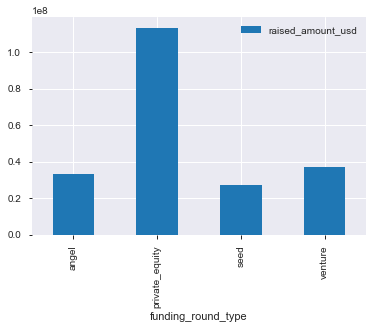

In [47]:
##plot showing the the average amount of investment in each funding type 
plot1 = round(fundingtype_subset.pivot_table(values=['raised_amount_usd'], index=['funding_round_type'], aggfunc=np.mean))
plot1.plot(kind='bar')
plt.show()

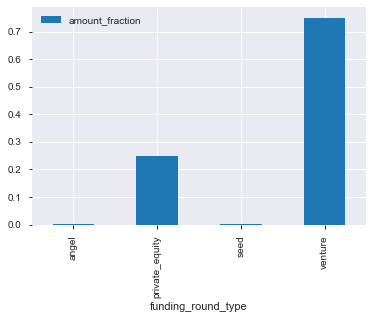

In [48]:
##plot showing the fraction of total investments (globally) in venture, seed, and private equity
plot1_fraction = fundingtype_subset.pivot_table(values=['amount_fraction'], index=['funding_round_type'], aggfunc=np.sum)
plot1_fraction.plot(kind='bar')
plt.show()

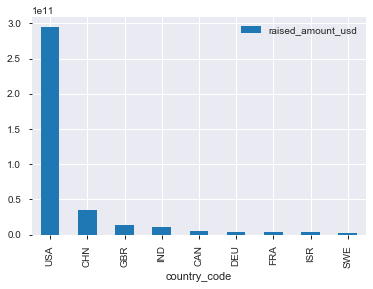

In [49]:
##plot showing the top 9 countries against the total amount of investments of funding type FT
plot1_fraction = top9.pivot_table(values=['raised_amount_usd'], index=['country_code'], aggfunc=np.sum)
plot1_fraction_sorted = round(plot1_fraction.sort_values(['raised_amount_usd'], ascending=False))
plot1_fraction_sorted.plot(kind='bar')
plt.show()

In [50]:
##plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart 
D1_plot = D1.groupby("primary_sector").raised_amount_usd.count().reset_index()
D1_plot.sort_values(["raised_amount_usd"], axis=0,ascending=False, inplace=True)
D1_plot = D1_plot.head(3)


D2_plot = D2.groupby("primary_sector").raised_amount_usd.count().reset_index()
D2_plot.sort_values(["raised_amount_usd"], axis=0,ascending=False, inplace=True)
D2_plot = D2_plot.head(3)


D3_plot = D3.groupby("primary_sector").raised_amount_usd.count().reset_index()
D3_plot.sort_values(["raised_amount_usd"], axis=0,ascending=False, inplace=True)
D3_plot = D3_plot.head(3)
D12 = pd.merge(D1_plot,D2_plot,how='outer',on='primary_sector')
D123 = pd.merge(D12,D3_plot,how='outer',on='primary_sector')



In [51]:
D123 = D123.rename(columns={"raised_amount_usd_x": "USD", "raised_amount_usd_y": "GBP" ,"raised_amount_usd": "INR"})
D123= D123.set_index("primary_sector")
D123.head()
D123.fillna(0)

,USD,GBP,INR
primary_sector,,,
Biotechnology,9436.0,0.0,497.0
Software,3209.0,0.0,185.0
Health Care,2718.0,0.0,0.0
E-Commerce,0.0,221.0,0.0
Clean Technology,0.0,91.0,152.0
Real Estate,0.0,88.0,0.0


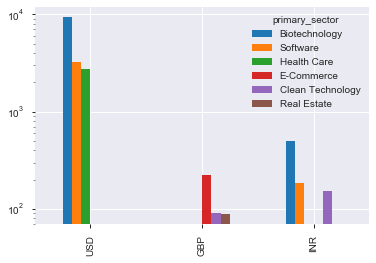

In [52]:
D123.T.plot.bar(logy=True)